**RDS (DS-UA 202) Spring 2022: Homework 1 Template**


This notebook is a template for problem 2. You should save a copy of this notebook and write your code in that copy. The code to setup the analysis is provided for you here. You should not edit or add to the setup code.

Some suggested steps are included as comments in the below code cells. You do not need to follow these suggestions (other solutions or approaches are acceptable).

# Setup

## Packages

In [1]:
!git clone https://github.com/lurosenb/superquail
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install folktables

Cloning into 'superquail'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 1), reused 20 (delta 1), pack-reused 0
Unpacking objects: 100% (24/24), done.
     |████████████████████████████████| 165 kB 4.9 MB/s 
     |████████████████████████████████| 2.6 MB 5.0 MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=54d2f3d0386d6ad1e3f273a2fef3e4bd07c05d9c9c8e08d478182d60015cf7c9
  Stored in directory: /root/.cache/pip/wheels/05/9f/ee/541a74be4cf5dad17430e64d3276370ea7b6a834a76cb4215a
Successfully built BlackBoxAuditing
     |████████████████████████████████| 92.6 MB 72 kB/s 
     |████████████████████████████████| 367 kB 47.4 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 3.2 MB 34.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installa

In [20]:
import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import time 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics import BinaryLabelDatasetMetric

import BlackBoxAuditing
%matplotlib inline

## Load data

We have included code to read in the folktables dataset. The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as is for the following analyses.

For more information on the this dataset, please see the following paper:
https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | Dropped from this analysis to focus on one sensitive attribute |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [3]:
np.random.seed(13) # do not change the seed

# read in the folktables dataset 
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=30000)
full_df = full_df.drop(columns='RAC1P') # drop race -- another protected attribute from our dataset

print(full_df.shape)
full_df.head()

(30000, 10)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
0,44.0,1.0,1.0,1.0,4220.0,6.0,10.0,40.0,1.0,0.0
1,66.0,2.0,20.0,2.0,4720.0,42.0,0.0,32.0,2.0,0.0
2,72.0,6.0,18.0,1.0,10.0,6.0,1.0,8.0,2.0,1.0
3,53.0,1.0,21.0,1.0,1460.0,457.0,0.0,40.0,1.0,1.0
4,55.0,1.0,16.0,1.0,220.0,6.0,1.0,40.0,1.0,0.0


## Set protected attribute and target

In [4]:
protected_attr = 'SEX' # set sex as the protected attribute
target = 'PINCP' # personal income as the target, note that [1 = >50k]

In [85]:
# convert this dataframe into an aif360 dataset
original_data = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=full_df,
    label_names=[target],
    protected_attribute_names=[protected_attr])
privileged_groups = [{protected_attr: 1}] 
unprivileged_groups = [{protected_attr: 2}]

## Split data

In [87]:
seed = 50
train_data, test_data = original_data.split([0.8], shuffle=True, seed=seed)

## Scale features in the data

In [88]:
scaler = MinMaxScaler()

train_data.features = scaler.fit_transform(train_data.features)
test_data.features = scaler.transform(test_data.features)

# convert to dataframes
train_df, _ = train_data.convert_to_dataframe()
test_df, _ = test_data.convert_to_dataframe()
print("Training set: ", train_df.shape)
print("Test set: ", test_df.shape)

# extract x (features) and y (target)
train_x = train_df.drop([target, protected_attr], axis=1)
train_y = train_df[target]
test_x = test_df.drop([target, protected_attr], axis=1)
test_y = test_df[target]

Training set:  (24000, 10)
Test set:  (6000, 10)


# 2 (a)

## Train a random forest model (baseline)

In [89]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [90]:
# use these hyperparameters in your call to RandomForestClassifier
n_estimators = 20
max_depth = 10

# set up the random forest model, using the hyperparameters
metric = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
metric.fit(train_x, train_y)
# fit the model using the training data (train_x, train_y)

RandomForestClassifier(max_depth=10, n_estimators=20)

## Calculate metrics

In [91]:
# the below function has been provided for you. You can use this function to
# convert your data to a StandardDataset format for use in AIF360
def transform_to_aif(df, target=target, protected_attr=protected_attr):
  '''convert a pandas.DataFrame to a StandardDataset used in AIF360'''

  sd = StandardDataset(
      df,
      label_name = target,
      favorable_classes = [1],
      protected_attribute_names = [protected_attr],
      privileged_classes = [[1]]
  )

  return sd

In [92]:
# calculate predictions from baseline RF model
#The variable below is the predictio from our random forest regression model
y_test_pred = metric.predict(test_x)


# The two variables below are the accuracy of our random forest regression model
auc = roc_auc_score(test_y, y_test_pred)
accuracy = accuracy_score(test_y, [pred_prob >= 0.5 for pred_prob in y_test_pred])

# convert predictions data to AIF StandardDataset
# also create AIF StandardDataset versions of training and test data
aif_test = transform_to_aif(test_df)

test_preds = test_df.copy()
test_preds[target] = y_test_pred

print(auc)
print(accuracy)

aif_train = transform_to_aif(train_df)
aif_test = transform_to_aif(test_df)
aif_test_pred = transform_to_aif(test_preds)

0.7952678106053666
0.8028333333333333


In [93]:
# calculate metrics
privileged_groups = [{protected_attr: 1}] 
unprivileged_groups = [{protected_attr: 2}]

metric_train = BinaryLabelDatasetMetric(
     aif_test, 
     unprivileged_groups=unprivileged_groups,
     privileged_groups=privileged_groups
  )

orig_vs_preds_metrics = ClassificationMetric(aif_test, aif_test_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

#fnp, fnu, fpp, fpu are false negative rates and false positive rates for previleged and unprevileged. The ones end with p is for privilege.
fnp = orig_vs_preds_metrics.false_negative_rate(privileged=True)
fnu = orig_vs_preds_metrics.false_negative_rate(privileged=False)

fpp = orig_vs_preds_metrics.false_positive_rate(privileged=True)
fpu = orig_vs_preds_metrics.false_positive_rate(privileged=False)

accuracy_for_privileged = 1 - fnp - fpp
accuracy_for_unprivileged = 1 - fnu - fpu
fpr_diff = (fpu - fpp)

#Accuracy and ROC on the top
print("The accuracy of our model is " + str(round(accuracy,3) * 100) + "% with 0.5 cutoff  for pred_prob")
print('The disparate impact is ' + str(metric_train.disparate_impact()) + ", indicating that the privileged group is favored.")
print("The accuracy for privileged group is " + str(accuracy_for_privileged))
print("The accuracy for privileged group is " + str(accuracy_for_unprivileged))
print("The difference in false positive rates between unprivileged and privileged is " + str(fpr_diff))

The accuracy of our model is 80.30000000000001% with 0.5 cutoff  for pred_prob
The disparate impact is 0.7509957069448372, indicating that the privileged group is favored.
The accuracy for privileged group is 0.593788226484761
The accuracy for privileged group is 0.5880619243328241
The difference in false positive rates between unprivileged and privileged is 0.00780061106090657


In [84]:
def func(df1, df2):
  orig_vs_preds_metrics = ClassificationMetric(df1, df2,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
  
  fnp = orig_vs_preds_metrics.false_negative_rate(privileged=True)
  fnu = orig_vs_preds_metrics.false_negative_rate(privileged=False)

  fpp = orig_vs_preds_metrics.false_positive_rate(privileged=True)
  fpu = orig_vs_preds_metrics.false_positive_rate(privileged=False)

  accuracy_for_privileged = 1 - fnp - fpp
  accuracy_for_unprivileged = 1 - fnu - fnp
  fpr_diff = (fpu - fpp)

#Accuracy and ROC on the top
  print("The accuracy of our model is " + str(round(accuracy,3) * 100) + "% with 0.5 cutoff  for pred_prob")
  print('The disparate impact is ' + str(metric_train.disparate_impact()))
  print("The accuracy for privileged group is " + str(accuracy_for_privileged))
  print("The accuracy for privileged group is " + str(accuracy_for_unprivileged))
  print("The difference in false positive rates between unprivileged and privileged is " + str(fpr_diff))


# 2 (b)

## Transform the original data using Disparate Impact Remover at five repair levels and calculate metrics

In [102]:
# the below function has been provided for you. You can use this function to
# plot the repair_level (on the x-axis) against a given metric,
# e.g. accuracy, on the y-axis
def plot_metric_repair(repair_levels, metric_values, metric_name):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_values, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel('Repair level')
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

def plot_metric_eta(etas, metric_values, metric_name):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(etas, metric_values, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel('ETA')
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

In [95]:
# use these repair levels
repair_levels = [0, 0.25, 0.5, 0.75, 1]

# transform the test and training data using DI-remover at the above repair
# levels and calculate metrics (you may wish to use a for loop)

accu = []
disparate_i = []
accuracy_p = []
accuracy_u = []
diff = []

metric = ['accuracy', 'disparate impact', 'accuracy for privileged', 'accuracy for unpriviledged', 'difference in false positive rates']
j = 0

for i in repair_levels:

  di = DisparateImpactRemover(repair_level=i)
  train = di.fit_transform(train_data)
  test = di.fit_transform(test_data)

  train.features = scaler.fit_transform(train_data.features)
  test.features = scaler.transform(test_data.features)

  # convert to dataframes
  train_df, _ = train.convert_to_dataframe()
  test_df, _ = test.convert_to_dataframe()
  # extract x (features) and y (target)
  train_x = train_df.drop([target, protected_attr], axis=1)
  train_y = train_df[target]
  test_x = test_df.drop([target, protected_attr], axis=1)
  test_y = test_df[target]

  # set up the random forest model, using the hyperparameters
  metric = RandomForestClassifier(n_estimators=20, max_depth=10)
  metric.fit(train_x, train_y)

  y_test_pred = metric.predict(test_x)

  test_preds = test_df.copy()
  test_preds[target] = y_test_pred

  # The two variables below are the accuracy of our random forest regression model
  auc = roc_auc_score(test_y, y_test_pred)
  accuracy = accuracy_score(test_y, y_test_pred)
  accu.append(accuracy)

  aif_train = transform_to_aif(train_df)
  aif_test = transform_to_aif(test_df)
  aif_test_pred = transform_to_aif(test_preds)

  metric_train = BinaryLabelDatasetMetric(
      aif_test_pred, 
      unprivileged_groups=unprivileged_groups,
      privileged_groups=privileged_groups
    )

  orig_vs_preds_metrics = ClassificationMetric(aif_test, aif_test_pred,
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

  #fnp, fnu, fpp, fpu are false negative rates and false positive rates for previleged and unprevileged. The ones end with p is for privilege.
  fnp = orig_vs_preds_metrics.false_negative_rate(privileged=True)
  fnu = orig_vs_preds_metrics.false_negative_rate(privileged=False)

  fpp = orig_vs_preds_metrics.false_positive_rate(privileged=True)
  fpu = orig_vs_preds_metrics.false_positive_rate(privileged=False)

  accuracy_for_privileged = 1 - fnp - fpp

  accuracy_p.append(accuracy_for_privileged)

  accuracy_for_unprivileged = 1 - fnu - fpu
  accuracy_u.append(accuracy_for_unprivileged)

  fpr_diff = (fpu - fpp)
  diff.append(fpr_diff)

  disparate_i.append(metric_train.disparate_impact())

  #Accuracy and ROC on the top
  print("At " + str(i) + ' repair level')
  print("The accuracy of our model is " + str(round(accuracy,3) * 100) + "% with 0.5 cutoff  for pred_prob")
  print('The disparate impact is ' + str(metric_train.disparate_impact()))
  print("The accuracy for privileged group is " + str(accuracy_for_privileged))
  print("The accuracy for unprivileged group is " + str(accuracy_for_unprivileged))
  print("The difference in false positive rates between unprivileged and privileged is " + str(fpr_diff) + "\n")


      




At 0 repair level
The accuracy of our model is 80.2% with 0.5 cutoff  for pred_prob
The disparate impact is 0.8354041066057112
The accuracy for privileged group is 0.5918428110808795
The accuracy for unprivileged group is 0.5821268521113488
The difference in false positive rates between unprivileged and privileged is 0.0012195789860770523

At 0.25 repair level
The accuracy of our model is 80.10000000000001% with 0.5 cutoff  for pred_prob
The disparate impact is 0.8399328388810547
The accuracy for privileged group is 0.5926012890898587
The accuracy for unprivileged group is 0.5725511414659645
The difference in false positive rates between unprivileged and privileged is 0.007647063425931355

At 0.5 repair level
The accuracy of our model is 80.60000000000001% with 0.5 cutoff  for pred_prob
The disparate impact is 0.8600519264485385
The accuracy for privileged group is 0.6022549389828649
The accuracy for unprivileged group is 0.5901425205724151
The difference in false positive rates betwee

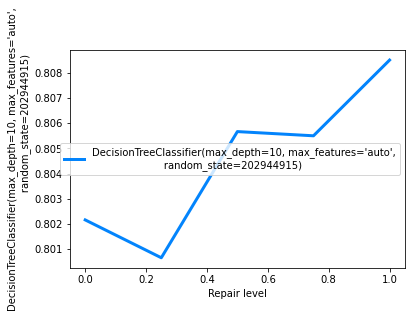

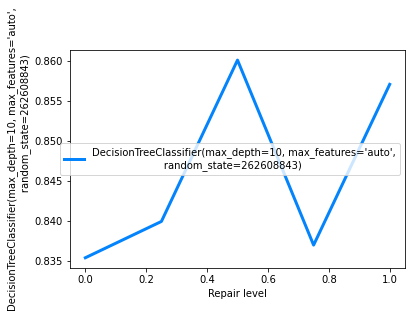

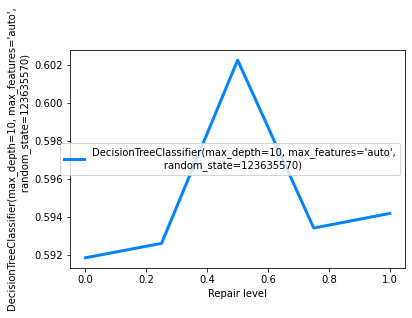

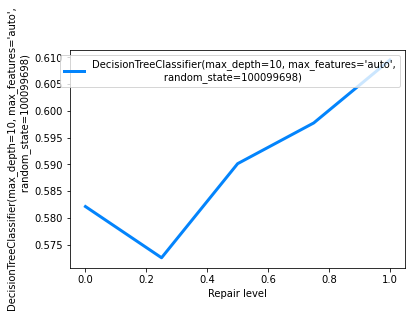

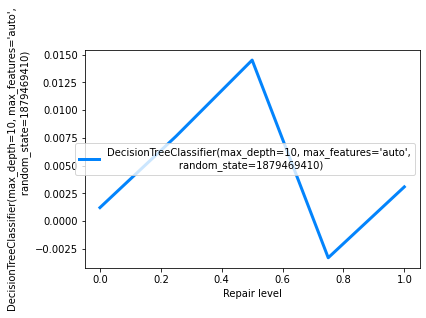

In [96]:
# plot each metric against the repair level
# (you can use the plot_metric_repair above)
l = [accu, disparate_i, accuracy_p, accuracy_u, diff]

for i in range(0,5):
  plot_metric_repair(repair_levels, l[i], metric[i])


In [106]:
print("First of all, all the metric values have increased or it's closed to being at its top when the repair level is at around 0.75")
print("Disparate impact is at its highest when the repair level is at 0.5. Compared with our original random forest regression model" +
      "I believe that we have a better accuracy at 0.75 of repair level.\n")
print("Moreover, the repair level increases along with the accuracy of unprivileged group, indicating that maybe a higher repair level could help us debias for the unprivileged group.")

First of all, all the metric values have increased or it's closed to being at its top when the repair level is at around 0.75
Disparate impact is at its highest when the repair level is at 0.5. Compared with our original random forest regression modelI believe that we have a better accuracy at 0.75 of repair level.

Moreover, the repair level increases along with the accuracy of unprivileged group, indicating that maybe a higher repair level could help us debias for the unprivileged group.


# 2 (c) 


## Train a Prejudice Remover model at three eta values and calculate metrics


In [67]:
help(PrejudiceRemover)

Help on class PrejudiceRemover in module aif360.algorithms.inprocessing.prejudice_remover:

class PrejudiceRemover(aif360.algorithms.transformer.Transformer)
 |  PrejudiceRemover(eta=1.0, sensitive_attr='', class_attr='')
 |  
 |  Prejudice remover is an in-processing technique that adds a
 |  discrimination-aware regularization term to the learning objective [6]_.
 |  
 |  References:
 |      .. [6] T. Kamishima, S. Akaho, H. Asoh, and J. Sakuma, "Fairness-Aware
 |         Classifier with Prejudice Remover Regularizer," Joint European
 |         Conference on Machine Learning and Knowledge Discovery in Databases,
 |         2012.
 |  
 |  Method resolution order:
 |      PrejudiceRemover
 |      aif360.algorithms.transformer.Transformer
 |      abc.ApplyDecorator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, eta=1.0, sensitive_attr='', class_attr='')
 |      Args:
 |          eta (double, optional): fairness penalty parameter
 |          sensitive_attr

In [100]:

etas = [0.01, 0.1, 1] # eta is the weight we apply to the fairness regularization parameter
accuracy_pc = []
accuracy_uc = []
diffc = []
acc_c = []
di_c = []

for i in etas:
  privileged_groups = [{protected_attr: 1}] 
  unprivileged_groups = [{protected_attr: 2}]
  pr_scaler = StandardScaler()
  ds = train_data.copy()#train_data is from our original trained data
  tpr = PrejudiceRemover(eta=i, sensitive_attr=protected_attr)
  ds.features = pr_scaler.fit_transform(ds.features)
  pr = tpr.fit(ds)
  t1 = pr.predict(test_data)
  metric_transf_train_t1 = BinaryLabelDatasetMetric(
    t1, 
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
  )
  t1_df = t1.convert_to_dataframe()[0]
  ds_df = ds.convert_to_dataframe()[0]

  d1 = metric_transf_train_t1.disparate_impact()
  di_c.append(d1)
  a = accuracy_score(test_df['PINCP'], t1_df['PINCP'])
  acc_c.append(a)

  test_preds = test_df.copy()
  test_preds[target] = t1_df[target]
  aif_test_pred1 = transform_to_aif(test_preds)

  orig_vs_preds_metrics = ClassificationMetric(aif_test, aif_test_pred1,
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)

  #fnp, fnu, fpp, fpu are false negative rates and false positive rates for previleged and unprevileged. The ones end with p is for privilege.
  fnp = orig_vs_preds_metrics.false_negative_rate(privileged=True)
  fnu = orig_vs_preds_metrics.false_negative_rate(privileged=False)

  fpp = orig_vs_preds_metrics.false_positive_rate(privileged=True)
  fpu = orig_vs_preds_metrics.false_positive_rate(privileged=False)

  accuracy_for_privileged = 1 - fnp - fpp
  accuracy_pc.append(accuracy_for_privileged)

  accuracy_for_unprivileged = 1 - fnu - fpu
  accuracy_uc.append(accuracy_for_unprivileged)

  fpr_diff = (fpu - fpp)
  diffc.append(fpr_diff)

  
  #Accuracy and ROC on the top
  print("At " + str(i) + ' eta')
  print("The accuracy of our model is " + str(round(a,3) * 100) + "% with 0.5 cutoff  for pred_prob")
  print('The disparate impact is ' + str(d1))
  print("The accuracy for privileged group is " + str(accuracy_for_privileged))
  print("The accuracy for unprivileged group is " + str(accuracy_for_unprivileged))
  print("The difference in false positive rates between unprivileged and privileged is " + str(fpr_diff) + "\n")

At 0.01 eta
The accuracy of our model is 72.6% with 0.5 cutoff  for pred_prob
The disparate impact is 0.7186049809503701
The accuracy for privileged group is 0.4368897883039463
The accuracy for unprivileged group is 0.550738630564839
The difference in false positive rates between unprivileged and privileged is -0.1879853376678755

At 0.1 eta
The accuracy of our model is 72.7% with 0.5 cutoff  for pred_prob
The disparate impact is 0.721563536499127
The accuracy for privileged group is 0.43868834945502544
The accuracy for unprivileged group is 0.5501003578539133
The difference in false positive rates between unprivileged and privileged is -0.1845554551464864

At 1 eta
The accuracy of our model is 72.8% with 0.5 cutoff  for pred_prob
The disparate impact is 0.7312860281911048
The accuracy for privileged group is 0.4424444293824698
The accuracy for unprivileged group is 0.550904408671653
The difference in false positive rates between unprivileged and privileged is -0.17458659499806356



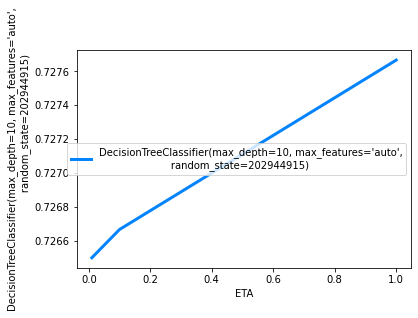

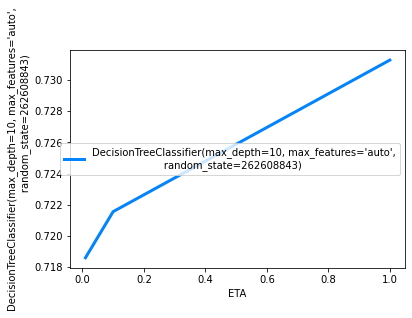

In [103]:
k = [acc_c, di_c, accuracy_pc, accuracy_uc, diffc]

for i in range(0,2):
  plot_metric_eta(etas, k[i], metric[i])

In [105]:
print("Compare to out graphs and metrics in part 2, we have gotten a model that has less accuracy. However, the descline of accuracy was probably compensated by the fact that the model is less accurate now on the privileged group with prejudice being removed")
print("It seems like with a higher ETA, out model would be more accurate and more fair with disparate impact being closer to 1.")
print("Compared to our model in part 2, we have a less accurate model probably resulting from the fact that prejudice remover is used, and the fact that prejuice remover model is an inprocessing method, which is not the same as out model in part2 which used a pre built random forest regression.")

Compare to out graphs and metrics in part 2, we have gotten a model that has less accuracy. However, the descline of accuracy was probably compensated by the fact that the model is less accurate now on the privileged group with prejudice being removed
It seems like with a higher ETA, out model would be more accurate and more fair with disparate impact being closer to 1.
Compared to our model in part 2, we have a less accurate model probably resulting from the fact that prejudice remover is used, and the fact that prejuice remover model is an inprocessing method, which is not the same as out model in part2 which used a pre built random forest regression.
